Instalación de la librería fast.ai (a continuación reiniciar el entorno de ejecución).

In [ ]:
!pip install fastai --upgrade

In [ ]:
from fastai.basics import *
from fastai.vision import models
from fastai.vision.all import *
from fastai.metrics import *
from fastai.data.all import *
from fastai.callback import *

from fastai.learner import defaults, Learner

from pathlib import Path
import random

Descarga de la librería de arquitecturas.

In [ ]:
!wget https://www.dropbox.com/s/cmoblvx5icdifwl/architectures.zip?dl=1 -O architectures.zip
!unzip architectures.zip

Descarga del dataset.

In [ ]:
!wget https://www.dropbox.com/s/p92cw15pleunmqe/dataset.zip?dl=1 -O dataset.zip
!unzip dataset.zip

Conexión con Drive para el almacenaje de los modelos.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Rutas a los directorios del dataset.

In [ ]:
path=Path('dataset/')
path_images = path/"Images"
path_labels = path/"Labels"
test_name = "test"

Función que dada la ruta de una imagen devuelve el path de su anotación.

In [ ]:
def get_y_fn (x):
    return Path(str(x).replace("Images","Labels"))

Clases: Background y Stoma.

In [ ]:
codes = np.loadtxt(path/'codes.txt', dtype=str)

Función que permite partir el dataset entre entrenamiento y test.

In [ ]:
def ParentSplitter(x):
    return Path(x).parent.name==test_name

# Data augmentation
Carga de la librería Albumentations.

In [ ]:
from albumentations import (
    Compose,
    OneOf,
    ElasticTransform,
    GridDistortion, 
    OpticalDistortion,
    HorizontalFlip,
    Flip,
    Rotate,
    Transpose,
    CLAHE,
    ShiftScaleRotate
)

class SegmentationAlbumentationsTransform(ItemTransform):
    split_idx = 0
    
    def __init__(self, aug): 
        self.aug = aug
        
    def encodes(self, x):
        img,mask = x
        aug = self.aug(image=np.array(img), mask=np.array(mask))
        return PILImage.create(aug["image"]), PILMask.create(aug["mask"])

Transformación que aplica a las imagenes giros horizontales, rotaciones y una operación de distorsión.

In [ ]:
transforms=Compose([HorizontalFlip(p=0.5),
                    Flip(p=0.5),
                    Rotate(p=0.40,limit=10)
                    ],p=1)

In [ ]:
transformPipeline=SegmentationAlbumentationsTransform(transforms)

Transformación que no aplica cambios a las imagenes.

In [ ]:
transforms2=Compose([],p=1)

In [ ]:
transform2Pipeline=SegmentationAlbumentationsTransform(transforms2)

Transformación que cambia todos los píxeles con valor 255 a valor 1 en las máscaras.

In [ ]:
class TargetMaskConvertTransform(ItemTransform):
    def __init__(self): 
        pass
    def encodes(self, x):
        img,mask = x
        
        #Convert to array
        mask = np.array(mask)
        
        mask[mask!=255]=0
        # Change 255 for 1
        mask[mask==255]=1
        
        
        # Back to PILMask
        mask = PILMask.create(mask)
        return img, mask

# Dataloaders
DataBlock de entrenamiento con aumento de datos.

In [ ]:
trainDB = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=partial(get_image_files,folders=['train']),
                   get_y=get_y_fn,
                   splitter=RandomSplitter(valid_pct=0.2),
                   item_tfms=[Resize((50,50)), TargetMaskConvertTransform(), transformPipeline],
                   batch_tfms=Normalize.from_stats(*imagenet_stats)
                  )

DataBlock de entrenamiento sin aumento de datos.

In [ ]:
train2DB = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=partial(get_image_files,folders=['train']),
                   get_y=get_y_fn,
                   splitter=RandomSplitter(valid_pct=0.2),
                   item_tfms=[Resize((50,50)), TargetMaskConvertTransform(), transform2Pipeline],
                   batch_tfms=Normalize.from_stats(*imagenet_stats)
                  )

DataBlock de test.

In [ ]:
testDB = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=partial(get_image_files,folders=['train','test']),
                   get_y=get_y_fn,
                   splitter=FuncSplitter(ParentSplitter),
                   item_tfms=[Resize((50,50)), TargetMaskConvertTransform(), transformPipeline],
                   batch_tfms=Normalize.from_stats(*imagenet_stats)
                  )

Creación de los dataloaders.

In [ ]:
bs = 2
trainDLS = trainDB.dataloaders(path_images,bs=bs)
train2DLS = trainDB.dataloaders(path_images,bs=bs)
testDLS = testDB.dataloaders(path_images,bs=bs)

Prueba de la carga de datos.

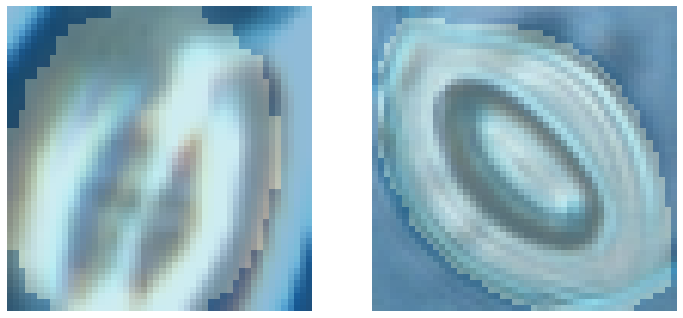

In [ ]:
trainDLS.show_batch(vmin=0,vmax=1,figsize=(12, 9))

# Modelos con aumento de datos
Definición del modelo.

In [ ]:
from architectures import HRNet
model = HRNet(backbone_name="hrnet_w32", nclass=2)

Creación del Learner con wd=1e-2 y definición del directorio de trabajo.

In [ ]:
learn = Learner(dls=trainDLS, model=model, metrics=[Dice(), JaccardCoeff()], wd=1e-2)
learn.model_dir = "/content/drive/MyDrive/Colab Notebooks/HRNet"

Freeze y elección de la tasa de aprendizaje.

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


Recorder

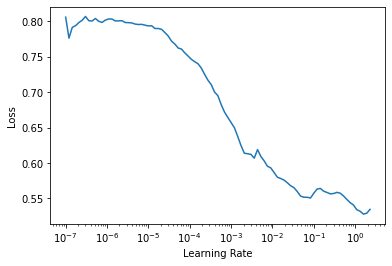

In [ ]:
learn.freeze()
learn.lr_find()
learn.recorder

Entrenamiento del modelo usando EarlyStoppingCallback según el valid_loss (min_delta=0.0001 y patience=2).

epoch,train_loss,valid_loss,dice,jaccard_coeff,time
0,0.328005,0.333392,0.917182,0.847033,26:31
1,0.299176,0.281140,0.927069,0.864053,26:32
2,0.267574,0.257600,0.931986,0.872635,26:25
3,0.268280,0.236217,0.936636,0.880824,26:29
4,0.233182,0.218026,0.941164,0.888866,26:27
5,0.212696,0.202173,0.947665,0.900536,26:31
6,0.215058,0.198427,0.948357,0.901787,26:20
7,0.193561,0.192602,0.949895,0.904572,26:36
8,0.195081,0.195845,0.949803,0.904405,26:38
9,0.206309,0.192421,0.949800,0.904399,26:37


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


Better model found at epoch 0 with valid_loss value: 0.33339184522628784.


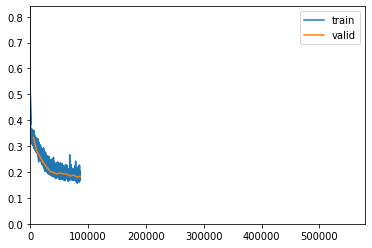

Better model found at epoch 1 with valid_loss value: 0.28114017844200134.
Better model found at epoch 2 with valid_loss value: 0.25759994983673096.
Better model found at epoch 3 with valid_loss value: 0.23621727526187897.
Better model found at epoch 4 with valid_loss value: 0.21802568435668945.
Better model found at epoch 5 with valid_loss value: 0.2021731287240982.
Better model found at epoch 6 with valid_loss value: 0.19842679798603058.
Better model found at epoch 7 with valid_loss value: 0.19260162115097046.
Better model found at epoch 9 with valid_loss value: 0.19242143630981445.
Better model found at epoch 10 with valid_loss value: 0.1917133629322052.
Better model found at epoch 11 with valid_loss value: 0.18415284156799316.
Better model found at epoch 13 with valid_loss value: 0.1807432472705841.
No improvement since epoch 13: early stopping


In [ ]:
name = "model_HRNet_hrnetW32_da_wd2"
learn.fit_one_cycle(100,slice(1e-5,1e-4),cbs=[
                                              EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0001, patience=2),
                                              ShowGraphCallback(),
                                              SaveModelCallback(monitor='valid_loss', min_delta=0.0001, fname=name, every_epoch=False)])

Comprobación de los resultados obtenidos en el modelo almacenado.

In [ ]:
learn.load("model_HRNet_hrnetW32_da_wd2")
learn.validate()

/usr/local/lib/python3.7/dist-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


(#3) [0.18165959417819977,0.9532310661081425,0.9106413414124319]

Unfreeze y elección de la tasa de aprendizaje.

/usr/local/lib/python3.7/dist-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


Recorder

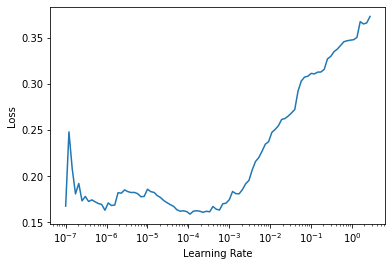

In [ ]:
learn.unfreeze()
learn.lr_find()
learn.recorder

Entrenamiento del modelo usando EarlyStoppingCallback según el valid_loss (min_delta=0.0001 y patience=2).

epoch,train_loss,valid_loss,dice,jaccard_coeff,time
0,0.186092,0.171416,0.955330,0.914479,27:38
1,0.173961,0.171993,0.955040,0.913948,27:22
2,0.167199,0.174364,0.954267,0.912534,27:40


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


Better model found at epoch 0 with valid_loss value: 0.1714162528514862.


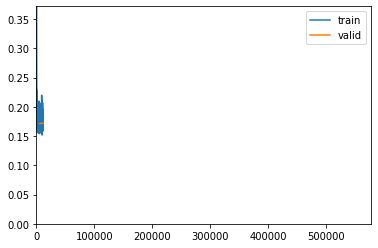

No improvement since epoch 0: early stopping


In [ ]:
name = "model_HRNet_hrnetW32_da_wd2_unfreeze"
learn.fit_one_cycle(100,slice(1e-5,1e-4),cbs=[
                                              EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0001, patience=2),
                                              ShowGraphCallback(),
                                              SaveModelCallback(monitor='valid_loss', min_delta=0.0001, fname=name, every_epoch=False)])

Comprobación de los resultados obtenidos en el modelo almacenado.

In [ ]:
learn.load("model_HRNet_hrnetW32_da_wd2_unfreeze")
learn.validate()

/usr/local/lib/python3.7/dist-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


(#3) [0.1714162528514862,0.9553295958153214,0.9144794300561392]



---


Definición del modelo.

In [ ]:
del model, learn
model = HRNet(backbone_name="hrnet_w32", nclass=2)

Creación del Learner con wd=1e-1 y definición del directorio de trabajo.

In [ ]:
learn = Learner(dls=trainDLS, model=model, metrics=[Dice(), JaccardCoeff()], wd=1e-1)
learn.model_dir = "/content/drive/MyDrive/Colab Notebooks/HRNet"

Freeze y elección de la tasa de aprendizaje.

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


Recorder

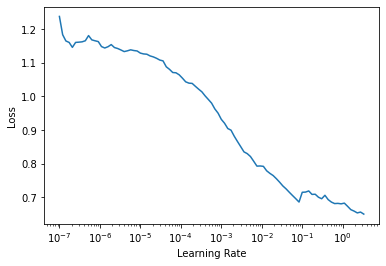

In [ ]:
learn.freeze()
learn.lr_find()
learn.recorder

Entrenamiento del modelo usando EarlyStoppingCallback según el valid_loss (min_delta=0.0001 y patience=2).

epoch,train_loss,valid_loss,dice,jaccard_coeff,time
0,0.315840,0.312177,0.916234,0.845416,27:56
1,0.298390,0.282190,0.924716,0.859974,27:05
2,0.280651,0.258134,0.930821,0.870593,27:23
3,0.226347,0.232960,0.938107,0.883428,27:23
4,0.208557,0.216036,0.943867,0.893700,28:00


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


Better model found at epoch 0 with valid_loss value: 0.31217730045318604.


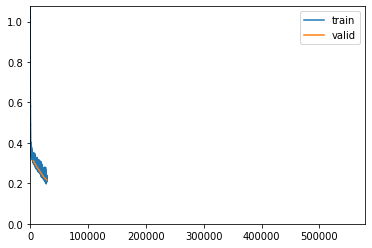

Better model found at epoch 1 with valid_loss value: 0.2821902334690094.
Better model found at epoch 2 with valid_loss value: 0.25813376903533936.
Better model found at epoch 3 with valid_loss value: 0.23295968770980835.
Better model found at epoch 4 with valid_loss value: 0.21603620052337646.


In [ ]:
name = "model_HRNet_hrnetW32_da_wd1"
learn.fit_one_cycle(100,slice(1e-5,1e-4),cbs=[
                                              EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0001, patience=2),
                                              ShowGraphCallback(),
                                              SaveModelCallback(monitor='valid_loss', min_delta=0.0001, fname=name, every_epoch=False)])

/usr/local/lib/python3.7/dist-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


Recorder

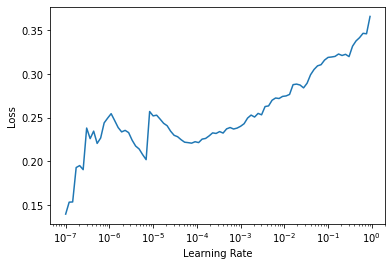

In [ ]:
learn.load("model_HRNet_hrnetW32_da_wd1")
learn.freeze()
learn.lr_find()
learn.recorder

epoch,train_loss,valid_loss,dice,jaccard_coeff,time
0,0.235966,0.200354,0.947189,0.899677,40:50
1,0.196055,0.196053,0.948807,0.902600,41:04
2,0.210237,0.195142,0.949201,0.903313,41:01
3,0.208557,0.190563,0.950469,0.905613,41:34
4,0.207979,0.192407,0.949519,0.903890,40:48
5,0.206902,0.190440,0.950536,0.905734,40:29


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


Better model found at epoch 0 with valid_loss value: 0.20035408437252045.


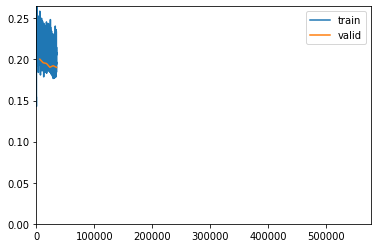

Better model found at epoch 1 with valid_loss value: 0.19605302810668945.
Better model found at epoch 2 with valid_loss value: 0.19514188170433044.
Better model found at epoch 3 with valid_loss value: 0.19056256115436554.
Better model found at epoch 5 with valid_loss value: 0.19043998420238495.


In [ ]:
name = "model_HRNet_hrnetW32_da_wd1"
learn.fit_one_cycle(100,slice(1e-5,1e-4),cbs=[
                                              EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0001, patience=2),
                                              ShowGraphCallback(),
                                              SaveModelCallback(monitor='valid_loss', min_delta=0.0001, fname=name, every_epoch=False)])

epoch,train_loss,valid_loss,dice,jaccard_coeff,time
0,0.191799,0.182338,0.952812,0.909877,27:13
1,0.202429,0.181621,0.952621,0.909528,27:14
2,0.185180,0.184511,0.952295,0.908934,27:20
3,0.199835,0.181993,0.953111,0.910423,27:09


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


Better model found at epoch 0 with valid_loss value: 0.18233773112297058.


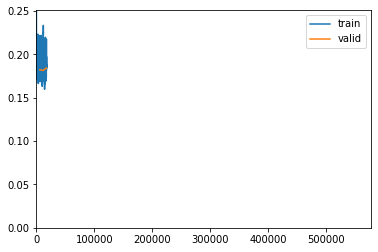

Better model found at epoch 1 with valid_loss value: 0.18162070214748383.
No improvement since epoch 1: early stopping


In [ ]:
name = "model_HRNet_hrnetW32_da_wd1"
learn.fit_one_cycle(100,slice(1e-5,1e-4),cbs=[
                                              EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0001, patience=2),
                                              ShowGraphCallback(),
                                              SaveModelCallback(monitor='valid_loss', min_delta=0.0001, fname=name, every_epoch=False)])

Comprobación de los resultados obtenidos en el modelo almacenado.

In [ ]:
learn.load("model_HRNet_hrnetW32_da_wd1")
learn.validate()

Unfreeze y elección de la tasa de aprendizaje.

/usr/local/lib/python3.7/dist-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


Recorder

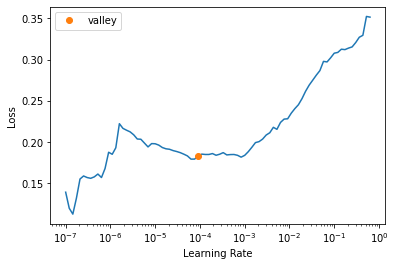

In [ ]:
learn.load("model_HRNet_hrnetW32_da_wd1_unfreeze")
learn.unfreeze()
learn.lr_find()
learn.recorder

Entrenamiento del modelo usando EarlyStoppingCallback según el valid_loss (min_delta=0.0001 y patience=2).

epoch,train_loss,valid_loss,dice,jaccard_coeff,time
0,0.180382,0.179704,0.953428,0.911000,26:36
1,0.177863,0.181120,0.953172,0.910533,26:25
2,0.199338,0.179231,0.953402,0.910953,26:32
3,0.180284,0.189784,0.951106,0.906771,26:31


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


Better model found at epoch 0 with valid_loss value: 0.1797042191028595.


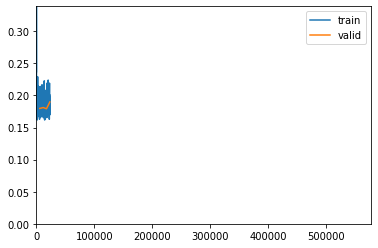

Better model found at epoch 2 with valid_loss value: 0.17923080921173096.


In [ ]:
name = "model_HRNet_hrnetW32_da_wd1_unfreeze"
learn.fit_one_cycle(100,slice(1e-5,1e-4),cbs=[
                                              EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0001, patience=2),
                                              ShowGraphCallback(),
                                              SaveModelCallback(monitor='valid_loss', min_delta=0.0001, fname=name, every_epoch=False)])

epoch,train_loss,valid_loss,dice,jaccard_coeff,time
0,0.181091,0.178595,0.953356,0.910869,26:56
1,0.188342,0.180864,0.952786,0.909829,26:52
2,0.190631,0.180667,0.953489,0.911112,26:56


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


Better model found at epoch 0 with valid_loss value: 0.17859503626823425.


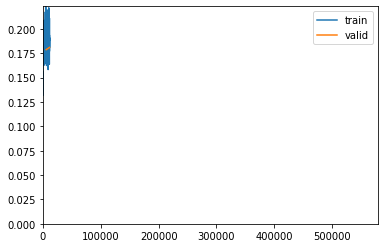

No improvement since epoch 0: early stopping


In [ ]:
name = "model_HRNet_hrnetW32_da_wd1_unfreeze"
learn.fit_one_cycle(100,slice(1e-5,1e-4),cbs=[
                                              EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0001, patience=2),
                                              ShowGraphCallback(),
                                              SaveModelCallback(monitor='valid_loss', min_delta=0.0001, fname=name, every_epoch=False)])

Comprobación de los resultados obtenidos en el modelo almacenado.

In [ ]:
learn.load("model_HRNet_hrnetW32_da_wd1_unfreeze")
learn.validate()

/usr/local/lib/python3.7/dist-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


(#3) [0.17859503626823425,0.9533559362896499,0.9108692910462856]

# Modelos sin aumento de datos
Definición del modelo.

In [ ]:
del model, learn
model = HRNet(backbone_name="hrnet_w32", nclass=2)

Creación del Learner con wd=1e-2 y definición del directorio de trabajo.

In [ ]:
learn = Learner(dls=train2DLS, model=model, metrics=[Dice(), JaccardCoeff()], wd=1e-2)
learn.model_dir = "/content/drive/MyDrive/Colab Notebooks/HRNet"

Freeze y elección de la tasa de aprendizaje.

/usr/local/lib/python3.7/dist-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


Recorder

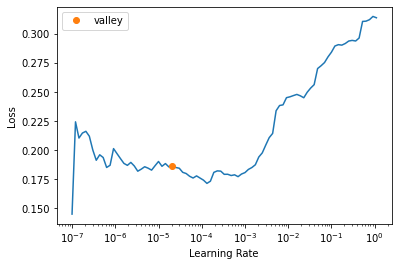

In [ ]:
learn.freeze()
learn.lr_find()
learn.recorder

Entrenamiento del modelo usando EarlyStoppingCallback según el valid_loss (min_delta=0.0001 y patience=2).

epoch,train_loss,valid_loss,dice,jaccard_coeff,time
0,0.324916,0.341857,0.914450,0.842384,26:10
1,0.282685,0.291351,0.923234,0.857413,25:42
2,0.302735,0.278382,0.922701,0.856494,25:59
3,0.270393,0.240410,0.936728,0.880987,26:02
4,0.237248,0.224845,0.940856,0.888318,26:10
5,0.219407,0.204511,0.947520,0.900274,25:54
6,0.211981,0.211828,0.945382,0.896420,25:43
7,0.222055,0.194376,0.949357,0.903596,25:59
8,0.201200,0.190339,0.950565,0.905788,25:44
9,0.192973,0.189905,0.950834,0.906275,25:50


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


Better model found at epoch 0 with valid_loss value: 0.3418571352958679.


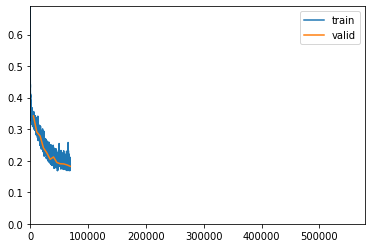

Better model found at epoch 1 with valid_loss value: 0.2913508117198944.
Better model found at epoch 2 with valid_loss value: 0.278382271528244.
Better model found at epoch 3 with valid_loss value: 0.24040968716144562.
Better model found at epoch 4 with valid_loss value: 0.22484484314918518.
Better model found at epoch 5 with valid_loss value: 0.20451070368289948.
Better model found at epoch 7 with valid_loss value: 0.19437624514102936.
Better model found at epoch 8 with valid_loss value: 0.19033850729465485.
Better model found at epoch 9 with valid_loss value: 0.18990497291088104.
Better model found at epoch 10 with valid_loss value: 0.18683910369873047.
Better model found at epoch 11 with valid_loss value: 0.18237020075321198.


In [ ]:
name = "model_HRNet_hrnetW32_wd2"
learn.fit_one_cycle(100,slice(1e-5,1e-4),cbs=[
                                              EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0001, patience=2),
                                              ShowGraphCallback(),
                                              SaveModelCallback(monitor='valid_loss', min_delta=0.0001, fname=name, every_epoch=False)])

epoch,train_loss,valid_loss,dice,jaccard_coeff,time
0,0.165929,0.172044,0.955008,0.913891,28:05
1,0.163582,0.171301,0.955410,0.914626,27:38
2,0.180839,0.171501,0.955259,0.914350,27:36
3,0.176157,0.172184,0.955387,0.914585,27:33


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


Better model found at epoch 0 with valid_loss value: 0.17204388976097107.


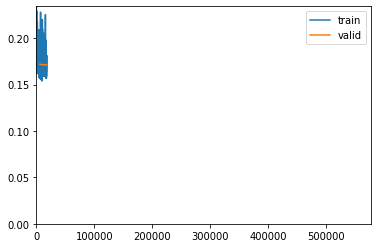

Better model found at epoch 1 with valid_loss value: 0.17130137979984283.
No improvement since epoch 1: early stopping


In [ ]:
name = "model_HRNet_hrnetW32_wd2"
learn.fit_one_cycle(100,slice(1e-5,1e-4),cbs=[
                                              EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0001, patience=2),
                                              ShowGraphCallback(),
                                              SaveModelCallback(monitor='valid_loss', min_delta=0.0001, fname=name, every_epoch=False)])

Comprobación de los resultados obtenidos en el modelo almacenado.

In [ ]:
learn.load("model_HRNet_hrnetW32_wd2")
learn.validate()

/usr/local/lib/python3.7/dist-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


(#3) [0.17130137979984283,0.9554098167189992,0.9146264554373936]

Unfreeze y elección de la tasa de aprendizaje.

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


Recorder

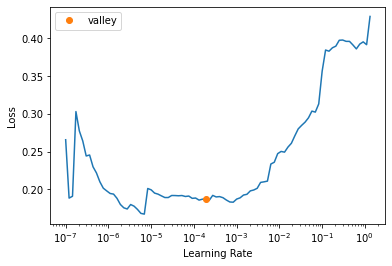

In [ ]:
learn.unfreeze()
learn.lr_find()
learn.recorder

Entrenamiento del modelo usando EarlyStoppingCallback según el valid_loss (min_delta=0.0001 y patience=2).

epoch,train_loss,valid_loss,dice,jaccard_coeff,time
0,0.182965,0.170683,0.955386,0.914582,27:36
1,0.175783,0.170145,0.955614,0.915001,27:53
2,0.166558,0.170583,0.955613,0.914998,27:43
3,0.190932,0.171359,0.955325,0.914470,27:35


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


Better model found at epoch 0 with valid_loss value: 0.1706829071044922.


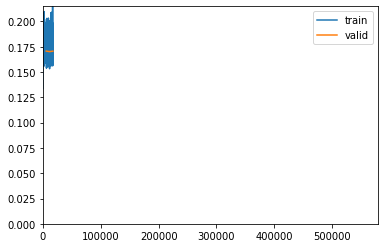

Better model found at epoch 1 with valid_loss value: 0.1701451539993286.
No improvement since epoch 1: early stopping


In [ ]:
name = "model_HRNet_hrnetW32_wd2_unfreeze"
learn.fit_one_cycle(100,slice(1e-5,1e-4),cbs=[
                                              EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0001, patience=2),
                                              ShowGraphCallback(),
                                              SaveModelCallback(monitor='valid_loss', min_delta=0.0001, fname=name, every_epoch=False)])

Comprobación de los resultados obtenidos en el modelo almacenado.

In [ ]:
learn.load("model_HRNet_hrnetW32_wd2_unfreeze")
learn.validate()

/usr/local/lib/python3.7/dist-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


(#3) [0.1701451539993286,0.9556143778706953,0.9150014684445562]



---


Definición del modelo.

In [ ]:
del model, learn
model = HRNet(backbone_name="hrnet_w32", nclass=2)

Creación del Learner con wd=1e-1 y definición del directorio de trabajo.

In [ ]:
learn = Learner(dls=train2DLS, model=model, metrics=[Dice(), JaccardCoeff()], wd=1e-1)
learn.model_dir = "/content/drive/MyDrive/Colab Notebooks/HRNet"

Freeze y elección de la tasa de aprendizaje.

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


Recorder

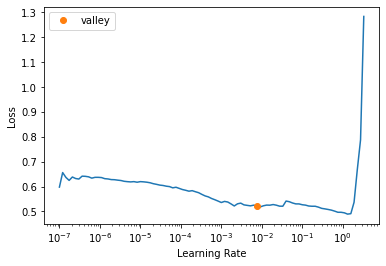

In [ ]:
learn.freeze()
learn.lr_find()
learn.recorder

Entrenamiento del modelo usando EarlyStoppingCallback según el valid_loss (min_delta=0.0001 y patience=2).

epoch,train_loss,valid_loss,dice,jaccard_coeff,time
0,0.322074,0.342179,0.917029,0.846772,26:31
1,0.295876,0.296308,0.926333,0.862775,26:21
2,0.271898,0.276110,0.930617,0.870238,26:23
3,0.252332,0.244933,0.937642,0.882605,26:35
4,0.239106,0.215135,0.943381,0.892830,26:49
5,0.226188,0.205848,0.945306,0.896284,26:53
6,0.192052,0.200277,0.949132,0.903189,26:55


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


Better model found at epoch 0 with valid_loss value: 0.34217938780784607.


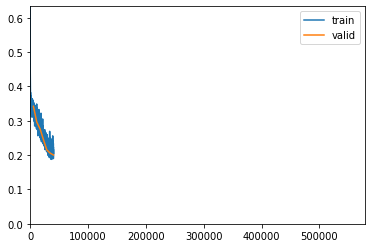

Better model found at epoch 1 with valid_loss value: 0.2963084876537323.
Better model found at epoch 2 with valid_loss value: 0.27611032128334045.
Better model found at epoch 3 with valid_loss value: 0.24493269622325897.
Better model found at epoch 4 with valid_loss value: 0.2151353359222412.
Better model found at epoch 5 with valid_loss value: 0.2058478593826294.
Better model found at epoch 6 with valid_loss value: 0.20027686655521393.


In [ ]:
name = "model_HRNet_hrnetW32_wd1"
learn.fit_one_cycle(100,slice(1e-5,1e-4),cbs=[
                                              EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0001, patience=2),
                                              ShowGraphCallback(),
                                              SaveModelCallback(monitor='valid_loss', min_delta=0.0001, fname=name, every_epoch=False)])

epoch,train_loss,valid_loss,dice,jaccard_coeff,time
0,0.209641,0.188321,0.950670,0.905978,26:38
1,0.188859,0.191680,0.950100,0.904944,26:19
2,0.194276,0.187876,0.951234,0.907004,27:09
3,0.193860,0.198293,0.948326,0.901729,26:57
4,0.189904,0.191371,0.950148,0.905031,26:43


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


Better model found at epoch 0 with valid_loss value: 0.18832145631313324.


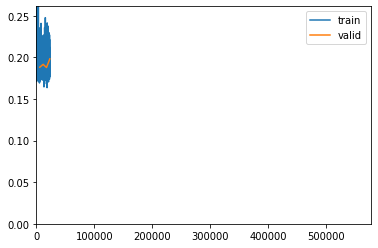

Better model found at epoch 2 with valid_loss value: 0.18787617981433868.
No improvement since epoch 2: early stopping


In [ ]:
name = "model_HRNet_hrnetW32_wd1"
learn.fit_one_cycle(100,slice(1e-5,1e-4),cbs=[
                                              EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0001, patience=2),
                                              ShowGraphCallback(),
                                              SaveModelCallback(monitor='valid_loss', min_delta=0.0001, fname=name, every_epoch=False)])

Comprobación de los resultados obtenidos en el modelo almacenado.

In [ ]:
learn.load("model_HRNet_hrnetW32_wd1")
learn.validate()

/usr/local/lib/python3.7/dist-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


(#3) [0.18787617981433868,0.9512342463707487,0.9070035354215229]

Unfreeze y elección de la tasa de aprendizaje.

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


Recorder

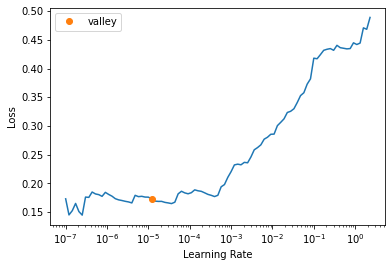

In [ ]:
learn.unfreeze()
learn.lr_find()
learn.recorder

Entrenamiento del modelo usando EarlyStoppingCallback según el valid_loss (min_delta=0.0001 y patience=2).

epoch,train_loss,valid_loss,dice,jaccard_coeff,time
0,0.190455,0.186828,0.951246,0.907025,26:31
1,0.182050,0.189132,0.950352,0.905400,26:46
2,0.185000,0.185060,0.951632,0.907726,26:33
3,0.193240,0.186620,0.950730,0.906088,27:17
4,0.195786,0.188711,0.950338,0.905374,27:51


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


Better model found at epoch 0 with valid_loss value: 0.18682831525802612.


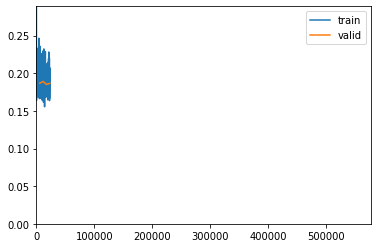

Better model found at epoch 2 with valid_loss value: 0.18505977094173431.
No improvement since epoch 2: early stopping


In [ ]:
name = "model_HRNet_hrnetW32_wd1_unfreeze"
learn.fit_one_cycle(100,slice(1e-5,1e-4),cbs=[
                                              EarlyStoppingCallback(monitor='valid_loss', min_delta=0.0001, patience=2),
                                              ShowGraphCallback(),
                                              SaveModelCallback(monitor='valid_loss', min_delta=0.0001, fname=name, every_epoch=False)])

Comprobación de los resultados obtenidos en el modelo almacenado.

In [ ]:
learn.load("model_HRNet_hrnetW32_wd1_unfreeze")
learn.validate()

/usr/local/lib/python3.7/dist-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


(#3) [0.18505977094173431,0.9516316563840704,0.907726432392832]

# Evaluación de resultados
## Modelos con aumento de datos
Carga del primer modelo en la CPU.

In [ ]:
learn.load("model_HRNet_hrnetW32_da_wd2")
aux=learn.model
aux=aux.cpu()

Asignación del dataloader de test y validación.

In [ ]:
learn.dls = testDLS
learn.validate()

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


(#3) [0.1652759462594986,0.9578576476143509,0.9191236162906579]

Comparación de resultado buscado contra resultado obtenido.

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


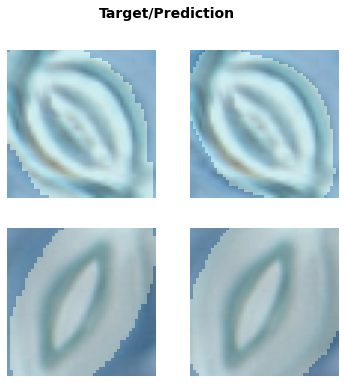

In [ ]:
learn.show_results(vmin=0,vmax=1)

Carga del segundo modelo en la CPU.

In [ ]:
learn.load("model_HRNet_hrnetW32_da_wd2_unfreeze")
aux=learn.model
aux=aux.cpu()

Asignación del dataloader de test y validación.

In [ ]:
learn.dls = testDLS
learn.validate()

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


(#3) [0.1578417718410492,0.9594869521873194,0.9221287077603777]

Comparación de resultado buscado contra resultado obtenido.

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


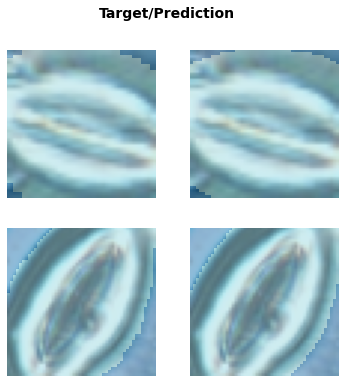

In [ ]:
learn.show_results(vmin=0,vmax=1)



---


Carga del tercer modelo en la CPU.

In [ ]:
learn.load("model_HRNet_hrnetW32_da_wd1")
aux=learn.model
aux=aux.cpu()

Asignación del dataloader de test y validación.

In [ ]:
learn.dls = testDLS
learn.validate()

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


(#3) [0.1669638305902481,0.9566319571324507,0.9168691370911489]

Comparación de resultado buscado contra resultado obtenido.

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


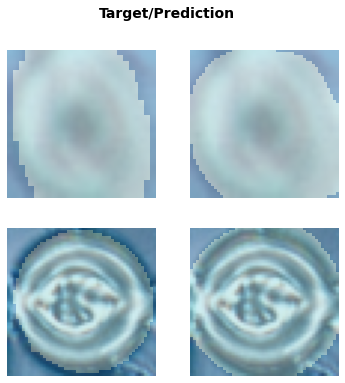

In [ ]:
learn.show_results(vmin=0,vmax=1)

Carga del cuarto modelo en la CPU.

In [ ]:
learn.load("model_HRNet_hrnetW32_da_wd1_unfreeze")
aux=learn.model
aux=aux.cpu()

Asignación del dataloader de test y validación.

In [ ]:
learn.dls = testDLS
learn.validate()

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


(#3) [0.16445042192935944,0.9573695533273529,0.918225202786483]

Comparación de resultado buscado contra resultado obtenido.

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


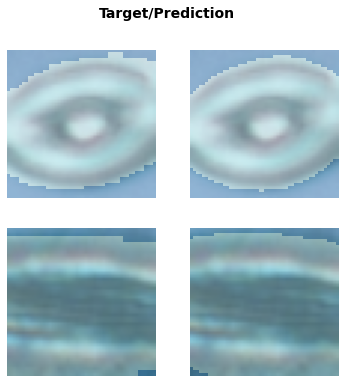

In [ ]:
learn.show_results(vmin=0,vmax=1)

## Modelos sin aumento de datos
Carga del primer modelo en la CPU.

In [ ]:
learn.load("model_HRNet_hrnetW32_wd2")
aux=learn.model
aux=aux.cpu()

Asignación del dataloader de test y validación.

In [ ]:
learn.dls = testDLS
learn.validate()

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


(#3) [0.15869633853435516,0.9591210133301158,0.9214529504516762]

Comparación de resultado buscado contra resultado obtenido.

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


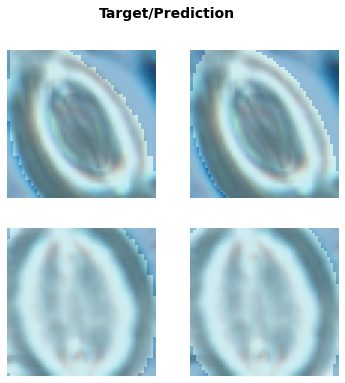

In [ ]:
learn.show_results(vmin=0,vmax=1)

Carga del segundo modelo en la CPU.

In [ ]:
learn.load("model_HRNet_hrnetW32_wd2_unfreeze")
aux=learn.model
aux=aux.cpu()

Asignación del dataloader de test y validación.

In [ ]:
learn.dls = testDLS
learn.validate()

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


(#3) [0.1573919951915741,0.9593275370170997,0.9218342669194495]

Comparación de resultado buscado contra resultado obtenido.

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


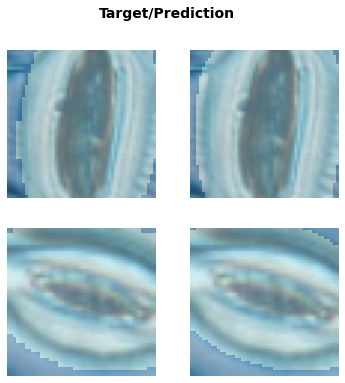

In [ ]:
learn.show_results(vmin=0,vmax=1)



---


Carga del tercer modelo en la CPU.

In [ ]:
learn.load("model_HRNet_hrnetW32_wd1")
aux=learn.model
aux=aux.cpu()

Asignación del dataloader de test y validación.

In [ ]:
learn.dls = testDLS
learn.validate()

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


(#3) [0.17123663425445557,0.9559997951733077,0.9157084364097485]

Comparación de resultado buscado contra resultado obtenido.

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


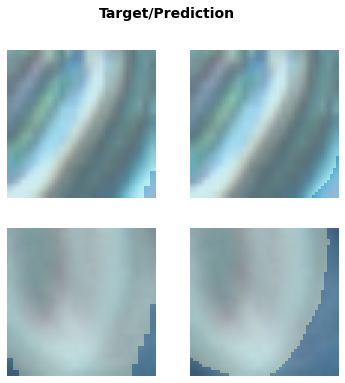

In [ ]:
learn.show_results(vmin=0,vmax=1)

Carga del cuarto modelo en la CPU.

In [ ]:
learn.load("model_HRNet_hrnetW32_wd1_unfreeze")
aux=learn.model
aux=aux.cpu()

Asignación del dataloader de test y validación.

In [ ]:
learn.dls = testDLS
learn.validate()

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


(#3) [0.16655968129634857,0.9569373542877756,0.9174303750800693]

Comparación de resultado buscado contra resultado obtenido.

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


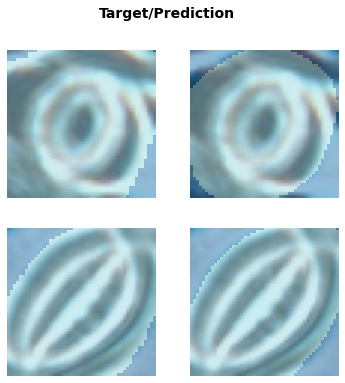

In [ ]:
learn.show_results(vmin=0,vmax=1)

# Exportación del mejor modelo
Carga del modelo en la CPU.

In [ ]:
learn.load("model_HRNet_hrnetW32_da_wd2_unfreeze")
learn.dls = testDLS
learn.validate()

/usr/local/lib/python3.7/dist-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


(#3) [0.15784193575382233,0.9594868837815722,0.9221285813951755]

In [ ]:
aux=learn.model
aux=aux.cpu()

Exportación del modelo mediante torch.jit.trace.

In [ ]:
import torchvision.transforms as transforms
img = PILImage.create(path_images/'train/1D2_0.png')
transformer=transforms.Compose([transforms.Resize((50,50)),
                                transforms.ToTensor(),
                                transforms.Normalize(
                                                    [0.485, 0.456, 0.406],
                                                    [0.229, 0.224, 0.225])])
img=transformer(img).unsqueeze(0)
img=img.cpu()

traced_cell=torch.jit.trace(aux, (img))
traced_cell.save("/content/drive/MyDrive/Colab Notebooks/HRNet/model_HRNet_hrnetW32.pkl")